In [318]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, default_collate
from datasets import load_dataset
import matplotlib.pyplot as plt
from functools import partial
import fastcore.all as fc
import torchvision.transforms.functional as TF
import torch.nn.functional as F
from operator import itemgetter, attrgetter
import torch.optim as optim
from functools import partial
from copy import copy
from torcheval.metrics import MulticlassAccuracy, Mean
from fastprogress import master_bar, progress_bar

In [319]:
name = 'fashion_mnist'
dsd = load_dataset(name)
x,y,*_ = dsd['train'].features.keys()

  0%|          | 0/2 [00:00<?, ?it/s]

In [320]:
def inplace(f):
    def _f(b):
        f(b)
        return b
    return _f

@inplace
def transformi(b):
    b[x] = [torch.flatten(TF.to_tensor(ele)) for ele in b[x]]

In [321]:
tds = dsd.with_transform(transformi)

In [322]:
def get_dls(train_ds, valid_ds, batch_size, **kwargs):
    return (
        DataLoader(train_ds, batch_size=batch_size, shuffle=True, **kwargs),
        DataLoader(valid_ds, batch_size=batch_size*2, shuffle=False, **kwargs)
    )

def collate_dict(x):
    g = itemgetter(*x.features)
    def _f(b):
        return g(default_collate(b))
    return _f

class DataLoaders:
    def __init__(self, *ds):
        self.train,self.valid = ds[:2]
    
    @classmethod
    def from_dd(cls, dd, batch_size, as_tuple=True, **kwargs):
        f = collate_dict(dd['train'])
        return cls(*get_dls(*dd.values(), batch_size=batch_size, collate_fn=f, **kwargs))    

In [323]:
bs = 1024
dls = DataLoaders.from_dd(tds, batch_size=bs)

In [324]:
def_device = 'mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu'

In [325]:
n,nh = 28*28,50
def get_model():
    return nn.Sequential(*[nn.Linear(n, nh), nn.ReLU(nh), nn.Linear(nh, 10)])

In [171]:
class Learner:
    def __init__(self, model, dls, loss_func=F.cross_entropy, opt_func=optim.SGD, lr=0.2):
        fc.store_attr()
    
    def calc_stats(self):
        n = len(self.xb)
        self.losses.append(self.loss*n)
        acc = (self.preds.argmax(dim=1)==self.yb).float().sum()
        self.accs.append(acc)
        self.ns.append(n)
    
    def report(self):
        n = sum(self.ns)
        acc = sum(self.accs)/n
        loss = sum(self.losses)/n
        print(f'acc:{acc:.3f}, loss:{loss:.3f}, training:{self.model.training}')
    
    def one_batch(self,):
        self.xb,self.yb = self.batch
        self.preds = self.model(self.xb)
        self.loss = self.loss_func(self.preds, self.yb)
        if self.model.training:
            self.loss.backward()
            self.opt.step()
            self.opt.zero_grad()
        with torch.no_grad():
            self.calc_stats()
    
    def one_epoch(self, train):
        self.model.train(train)
        self.dl = self.dls.train if train else self.dls.valid
        for self.iter, self.batch in enumerate(self.dl):
            self.one_batch()
        self.report()
        
    def fit(self, n_epochs=1):
        self.n_epochs = n_epochs
        self.accs,self.losses,self.ns = [],[],[]
        self.opt = self.opt_func(self.model.parameters(), lr=self.lr)
        for self.epoch in range(n_epochs):
            self.one_epoch(True)
        with torch.no_grad():
            self.one_epoch(False)

In [172]:
learner = Learner(get_model(), dls, lr=0.1)

In [173]:
learner.fit(3)

acc:0.590, loss:1.351, training:True
acc:0.647, loss:1.081, training:True
acc:0.682, loss:0.954, training:True
acc:0.687, loss:0.939, training:False


In [174]:
class CancelFitException(Exception):
    pass

class CancelEpochException(Exception):
    pass

class CancelBatchException(Exception):
    pass

In [193]:
def run_cbs(cbs, method_nm, learn=None):
    for cb in sorted(cbs, key=attrgetter('order')):
        method = getattr(cb, method_nm, None)
        if method is not None:
            method(learn)

In [194]:
class Callback:
    order = 0

In [397]:
class with_cbs:
    def __init__(self, nm):
        self.nm = nm 
    
    def __call__(self, f):
        def _f(o, *args, **kwargs):
            try:
                o.callback(f'before_{self.nm}')
                f(o, *args, **kwargs)
                o.callback(f'after_{self.nm}')
            except globals()[f'Cancel{self.nm.title()}Exception'] as e:
                pass
            finally:
                o.callback(f'cleanup_{self.nm}')
        return _f

In [349]:
class Learner:
    def __init__(self, model, dls=(0,), loss_func=F.cross_entropy, lr=0.1, opt_func=optim.SGD, cbs=None):
        cbs = fc.L(cbs)
        fc.store_attr()
    
    @property
    def training(self):
        return self.model.training
    
    def __getattr__(self, name):
        if name in ('predict', 'get_loss', 'backward', 'step', 'zero_grad'):
            return partial(self.callback, name) 
        raise AttributeError(name)
    
    def callback(self, method_nm):
        run_cbs(self.cbs, method_nm, self)
    
    @with_cbs('batch')
    def _one_batch(self):
        self.predict()
        self.callback('after_predict')
        self.get_loss()
        self.callback('after_loss')
        if self.training:
            self.backward()
            self.callback('after_backward')
            self.step()
            self.callback('after_step')
            self.zero_grad()
    
    @with_cbs('epoch')
    def _one_epoch(self):
        for self.iter, self.batch in enumerate(self.dl):
            self._one_batch()
    
    def one_epoch(self, train):
        self.model.train(train)
        self.dl = self.dls.train if train else self.dls.valid
        self._one_epoch()
    
    @with_cbs('fit')
    def _fit(self, train, valid):
        for self.epoch in self.epochs:
            if train:
                self.one_epoch(True)
            if valid:
                self.one_epoch(False)
    
    def fit(self, n_epochs=1, lr=None, cbs=None, valid=True, train=True):
        cbs = fc.L(cbs)
        for cb in cbs:
            self.cbs.append(cb)
        try:
            self.n_epochs = n_epochs
            self.epochs = range(n_epochs)
            self.lr = lr if lr is not None else self.lr
            self.opt = self.opt_func(self.model.parameters(), lr=self.lr)
            self._fit(train, valid)
        finally:
            for cb in cbs:
                self.cbs.remove(cb)     

In [350]:
learner = Learner(get_model(), dls)

In [351]:
class TrainerCB(Callback):
    def __init__(self, n_inp):
        self.n_inp = n_inp
        
    def predict(self, learn):
        learn.preds = learn.model(*learn.batch[:self.n_inp])
    
    def get_loss(self, learn):
        learn.loss = learn.loss_func(learn.preds, *learn.batch[self.n_inp:])
    
    def backward(self, learn):
        learn.loss.backward()

    def step(self, learn):
        learn.opt.step()
    
    def zero_grad(self, learn):
        learn.opt.zero_grad()

In [352]:
learner = Learner(get_model(), dls, cbs=[TrainerCB(1)])

In [353]:
learner.fit(1)

In [354]:
class MetricsCB(Callback):
    def __init__(self, *ms, **metrics):
        for o in ms:
            metrics[o.__name__] = o
        self.metrics = metrics
        self.all_metrics = copy(metrics)
        self.all_metrics['loss'] = self.loss = Mean()
    
    def _log(self, d):
        print(d)
    
    def before_fit(self, learn):
        learn.metrics = self
    
    def before_epoch(self, learn):
        [o.reset() for o in self.all_metrics.values()]
    
    def after_epoch(self, learn):
        log = {k:f'{v.compute():.3f}' for k,v in self.all_metrics.items()}
        log['epoch'] = learn.epoch
        log['train'] = 'train' if learn.training else 'eval'
        self._log(log)
    
    def after_batch(self, learn):
        x,y,*_ = learn.batch
        for m in self.metrics.values():
            m.update(learn.preds, y)
        self.loss.update(learn.loss, weight=len(x))        

In [355]:
learner = Learner(get_model(), copy(dls), cbs=[TrainerCB(1), MetricsCB(accuracy=MulticlassAccuracy())])

In [356]:
learner.fit(3)

{'accuracy': '0.554', 'loss': '1.448', 'epoch': 0, 'train': 'train'}
{'accuracy': '0.668', 'loss': '0.937', 'epoch': 0, 'train': 'eval'}
{'accuracy': '0.707', 'loss': '0.819', 'epoch': 1, 'train': 'train'}
{'accuracy': '0.730', 'loss': '0.753', 'epoch': 1, 'train': 'eval'}
{'accuracy': '0.752', 'loss': '0.700', 'epoch': 2, 'train': 'train'}
{'accuracy': '0.762', 'loss': '0.680', 'epoch': 2, 'train': 'eval'}


In [357]:
class ProgressCB(Callback):
    order = MetricsCB.order+1
    def __init__(self, plot=False): self.plot = plot
    def before_fit(self, learn):
        learn.epochs = self.mbar = master_bar(learn.epochs)
        self.first = True
        if hasattr(learn, 'metrics'): learn.metrics._log = self._log
        self.losses = []
        self.val_losses = []

    def _log(self, d):
        if self.first:
            self.mbar.write(list(d), table=True)
            self.first = False
        self.mbar.write(list(d.values()), table=True)

    def before_epoch(self, learn): learn.dl = progress_bar(learn.dl, leave=False, parent=self.mbar)
    def after_batch(self, learn):
        learn.dl.comment = f'{learn.loss:.3f}'
        if self.plot and hasattr(learn, 'metrics') and learn.training:
            self.losses.append(learn.loss.item())
            if self.val_losses: 
                self.mbar.update_graph([[fc.L.range(self.losses), self.losses],\
                [fc.L.range(learn.epoch).map(lambda x: (x+1)*len(learn.dls.train)), self.val_losses]])
                
    def after_epoch(self, learn): 
        if not learn.training:
            if self.plot and hasattr(learn, 'metrics'): 
                self.val_losses.append(learn.metrics.all_metrics['loss'].compute())
                self.mbar.update_graph([[fc.L.range(self.losses), self.losses],\
                        [fc.L.range(learn.epoch+1).map(lambda x: (x+1)*len(learn.dls.train)), self.val_losses]])

In [359]:
class ProgressCB(Callback):
    order = MetricsCB.order + 1
    def __init__(self, plot=False):
        self.plot = plot
    
    def before_fit(self, learn):
        learn.epochs = self.mbar = master_bar(learn.epochs)
        self.first = True
        if hasattr(learn, 'metrics'):
            learn.metrics._log = self._log
        self.losses = []
        self.val_losses = []
    
    def _log(self, d):
        if self.first:
            self.mbar.write(list(d), table=True)
            self.first = False
        self.mbar.write(list(d.values()), table=True)
    
    def before_epoch(self, learn):
        learn.dl = progress_bar(learn.dl, leave=False, parent=self.mbar)
    
    def after_batch(self, learn):
        learn.dl.comment = f'{learn.loss:.3f}'
        if self.plot and hasattr(learn, 'metrics') and learn.training:
            self.losses.append(learn.loss.item())
            if self.val_losses:
                self.mbar.update_graph([[fc.L.range(self.losses), self.losses],\
                [[fc.L.range(learn.epoch).map(lambda x: (x+1)*len(learn.dls.train)) ,self.val_losses]]])
    
    def after_epoch(self, learn):
        if not learn.training:
            if self.plot and hasattr(learn, 'metrics'):
                self.val_losses.append(learn.metrics.all_metrics['loss'].compute())
                self.mbar.update_graph([[fc.L.range(self.losses), self.losses],\
                        [fc.L.range(learn.epoch+1).map(lambda x: (x+1)*len(learn.dls.train)), self.val_losses]])

In [366]:
learner = Learner(get_model(), copy(dls), lr=0.2,\
                  cbs=[TrainerCB(1), MetricsCB(accuracy=MulticlassAccuracy()), ProgressCB(plot=True)])

accuracy,loss,epoch,train
0.592,1.180,0,train
0.711,0.781,0,eval


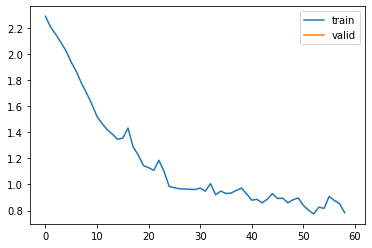

In [367]:
learner.fit(1)

In [368]:
class TrainLearner(Learner):
    def predict(self):
        self.preds = self.model(self.batch[0])
    
    def get_loss(self):
        self.loss = self.loss_func(self.preds, self.batch[1])
    
    def backward(self):
        self.loss.backward()

    def step(self):
        self.opt.step()
    
    def zero_grad(self):
        self.opt.zero_grad()

In [380]:
class MomentumLearner(TrainLearner):
    def __init__(self, model, dls, loss_func=None, lr=None, cbs=None, opt_func=optim.SGD, mom=0.85):
        self.mom = mom
        super().__init__(model, dls=dls, loss_func=loss_func, lr=lr, cbs=cbs, opt_func=opt_func)
    
    def zero_grad(self):
        with torch.no_grad():
            for p in self.model.parameters():
                p.grad *= self.mom  

In [388]:
learner = MomentumLearner(get_model(), copy(dls), lr=0.1, loss_func=F.cross_entropy,\
                  cbs=[MetricsCB(accuracy=MulticlassAccuracy()), ProgressCB(plot=True)])

accuracy,loss,epoch,train
0.670,0.965,0,train
0.790,0.582,0,eval


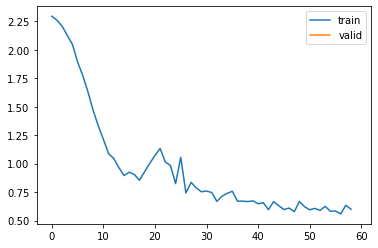

In [389]:
learner.fit(1)

In [395]:
import math

class LRFinderCB(Callback):
    def __init__(self, lr_mult=1.3):
        fc.store_attr()
    
    def before_fit(self, learn):
        self.lrs,self.losses = [],[]
        self.min = math.inf
    
    def after_batch(self, learn):
        if not learn.training:
            raise CancelEpochException()
        self.lrs.append(learn.opt.param_groups[0]['lr'])
        loss = learn.loss
        self.losses.append(loss.item())
        if loss < self.min:
            self.min = loss
        if loss > self.min*3:
            raise CancelFitException()
        for g in learn.opt.param_groups:
            g['lr'] *= self.lr_mult

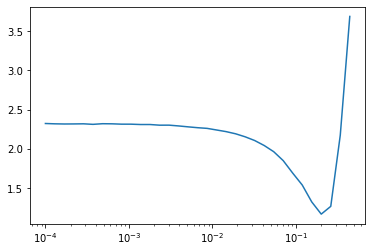

In [398]:
lrfinder = LRFinderCB()
learner = MomentumLearner(get_model(), copy(dls), lr=1e-4, loss_func=F.cross_entropy,\
                  cbs=[MetricsCB(accuracy=MulticlassAccuracy()), lrfinder])
learner.fit(1)
plt.plot(lrfinder.lrs, lrfinder.losses)
plt.xscale('log')

In [401]:
from torch.optim.lr_scheduler import ExponentialLR

class LRFinderCB(Callback):
    def __init__(self, gamma=1.3, max_mult=3):
        fc.store_attr()
    
    def before_fit(self, learn):
        self.sched = ExponentialLR(learn.opt, self.gamma)
        self.lrs,self.losses = [],[]
        self.min = math.inf
        
    def after_batch(self, learn):
        if not learn.training:
            raise CancelEpochException()
        self.lrs.append(learn.opt.param_groups[0]['lr'])
        loss = learn.loss.item()
        self.losses.append(loss)
        if loss < self.min:
            self.min = loss
        if math.isnan(loss) or (loss > self.min*self.max_mult):
            raise CancelFitException()
        self.sched.step()
    
    def cleanup_fit(self, learn):
        plt.plot(self.lrs, self.losses)
        plt.xscale('log')

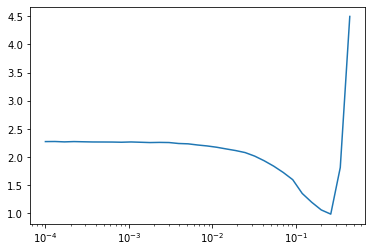

In [402]:
lrfinder = LRFinderCB()
learner = MomentumLearner(get_model(), copy(dls), lr=1e-4, loss_func=F.cross_entropy,\
                  cbs=[MetricsCB(accuracy=MulticlassAccuracy())])
learner.fit(3, cbs=[lrfinder])

In [ ]:
@fc.patch
def lr_find(self:Learner, gamma=1.3, max_mult=3, start_lr=1e-5, max_epochs=10):
    self.fit(max_epochs, lr=start_lr, cbs=LRFinderCB(gamma=gamma, max_mult=max_mult))

In [403]:
fc.patch??

In [404]:
@fc.patch
def lr_find(self:Learner, gamma=1.3, max_mult=3, start_lr=1e-5, max_epochs=10):
    self.fit(max_epochs, lr=start_lr, cbs=LRFinderCB(gamma=gamma, max_mult=max_mult))

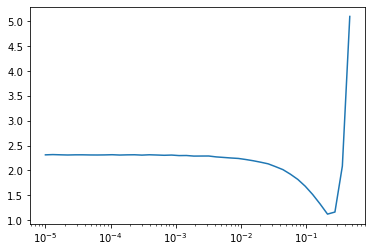

In [406]:
MomentumLearner(get_model(), dls, F.cross_entropy, cbs=[]).lr_find()